<a href="https://colab.research.google.com/github/rcoborod/hello-world/blob/preproceso-pandas/tf_lstm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# New Section

All imports regarding data processing modeling, fitting , evaluation and prediction

In [0]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import collections
import time
import tensorflow as tf
from tensorflow.keras import layers
np.set_printoptions(precision=4)

Some structural variables


In [0]:
batch_size = 64
# Each MNIST image batch is a tensor of shape (batch_size, 28, 28).
# Each input sequence will be of size (28, 28) (height is treated like time).
input_dim = 28

units = 64
output_size = 10  # labels are from 0 to 9

# Build the RNN model
def build_model(allow_cudnn_kernel=True):
  # CuDNN is only available at the layer level, and not at the cell level.
  # This means `LSTM(units)` will use the CuDNN kernel,
  # while RNN(LSTMCell(units)) will run on non-CuDNN kernel.
  if allow_cudnn_kernel:
    # The LSTM layer with default options uses CuDNN.
    lstm_layer = tf.keras.layers.LSTM(units, input_shape=(None, input_dim))
  else:
    # Wrapping a LSTMCell in a RNN layer will not use CuDNN.
    lstm_layer = tf.keras.layers.RNN(
        tf.keras.layers.LSTMCell(units),
        input_shape=(None, input_dim))
  model = tf.keras.models.Sequential([
      lstm_layer,
      tf.keras.layers.BatchNormalization(),
      tf.keras.layers.Dense(output_size)]
  )
  return model


In [0]:
mnist = tf.keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0
sample, sample_label = x_train[0], y_train[0]

11493376/11490434 [==============================] - 0s 0us/step


In [0]:
x_train, y_train

(array([[[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],
 
        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],
 
        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],
 
        ...,
 
        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],


In [0]:
model = build_model(allow_cudnn_kernel=True)

model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
              optimizer='sgd',
              metrics=['accuracy'])

In [0]:
model.fit(x_train, y_train,
          validation_data=(x_test, y_test),
          batch_size=batch_size,
          epochs=5)

Epoch 1/5
938/938 [==============================] - 17s 18ms/step - loss: 0.9534 - accuracy: 0.6973 - val_loss: 0.5476 - val_accuracy: 0.8283
Epoch 2/5
938/938 [==============================] - 16s 18ms/step - loss: 0.3908 - accuracy: 0.8826 - val_loss: 0.2947 - val_accuracy: 0.9041
Epoch 3/5
938/938 [==============================] - 16s 17ms/step - loss: 0.2491 - accuracy: 0.9243 - val_loss: 0.3068 - val_accuracy: 0.9011
Epoch 4/5
938/938 [==============================] - 17s 18ms/step - loss: 0.1927 - accuracy: 0.9413 - val_loss: 0.3443 - val_accuracy: 0.8832
Epoch 5/5
938/938 [==============================] - 16s 17ms/step - loss: 0.1617 - accuracy: 0.9500 - val_loss: 0.1710 - val_accuracy: 0.9477


In [0]:
slow_model = build_model(allow_cudnn_kernel=False)
slow_model.set_weights(model.get_weights())
slow_model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
                   optimizer='sgd', 
                   metrics=['accuracy'])
slow_model.fit(x_train, y_train, 
               validation_data=(x_test, y_test), 
               batch_size=batch_size,
               epochs=1)  # We only train for one epoch because it's slower.

938/938 [==============================] - 17s 18ms/step - loss: 0.1428 - accuracy: 0.9562 - val_loss: 0.2459 - val_accuracy: 0.9202


Predicted result is: [5], target result is: 5


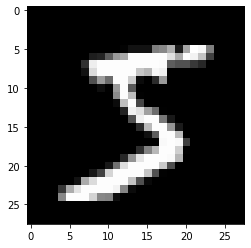

In [0]:
with tf.device('CPU:0'):
  cpu_model = build_model(allow_cudnn_kernel=True)
  cpu_model.set_weights(model.get_weights())
  result = tf.argmax(cpu_model.predict_on_batch(tf.expand_dims(sample, 0)), axis=1)
  print('Predicted result is: %s, target result is: %s' % (result.numpy(), sample_label))
  plt.imshow(sample, cmap=plt.get_cmap('gray'))

In [0]:
range_ds = tf.data.Dataset.range(100000)
batches = range_ds.batch(10, drop_remainder=True)

for batch in batches.take(5):
  print(batch.numpy())

[0 1 2 3 4 5 6 7 8 9]
[10 11 12 13 14 15 16 17 18 19]
[20 21 22 23 24 25 26 27 28 29]
[30 31 32 33 34 35 36 37 38 39]
[40 41 42 43 44 45 46 47 48 49]


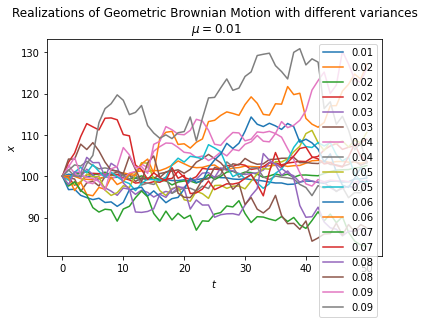

In [0]:
# Python code for the plot

import numpy as np
import matplotlib.pyplot as plt

mu = 0.0
n = 50
dt = 0.1
x0 = 100
np.random.seed(1)

sigma = np.arange(0.01, 0.1, 0.005)

x = np.exp(
    (mu - sigma ** 2 / 2) * dt
    + sigma * np.random.normal(0, np.sqrt(dt), size=(len(sigma), n)).T
)
x = np.vstack([np.ones(len(sigma)), x])
x = x0 * x.cumprod(axis=0)

plt.plot(x)
plt.legend(np.round(sigma, 2))
plt.xlabel("$t$")
plt.ylabel("$x$")
plt.title(
    "Realizations of Geometric Brownian Motion with different variances\n $\mu=0.01$"
)
plt.show()